# Predicting bulk moduli with matminer

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rhennig/EMA6938/blob/main/Notebooks/12.MachineLearningBulkModulusRandomForest.ipynb)

-----------------------------------------------------------------------------
## Fit data mining models to ~10,000 calculated bulk moduli from Materials Project
-----------------------------------------------------------------------------

**Time to complete: 30 minutes**

The tutorial is based on the matminer tutorials from https://github.com/hackingmaterials/matminer_examples.

This notebook is an example of using the MP data retrieval tool :code:`retrieve_MP.py` to retrieve computed bulk moduli from the
<a href="https://materialsproject.org">Materials Project</a> database in the form of a pandas dataframe, using matminer's tools to populate the dataframe with descriptors/features from pymatgen, and then fitting regression models from the scikit-learn library to the dataset.


## Overview

In this notebook, we will:
1. Load and examine a dataset in a pandas dataframe
2. Add descriptors to the dataframe using matminer
3. Train, compare, and visualize two machine learning methods with scikit-learn and Plotly.

## Software installation

To run this and other Python notebooks, I recommend using Jupyter. Here are the steps to install JupyterLab:

- If you do not have Conda already installed on your computer, please follow the instructions at https://docs.conda.io/en/latest/miniconda.html. Then you can proceed to install JupyterLab, which will also install Python if it is not already installed.

- `conda install jupyterlab`

- `conda install ipywidgets`

For the visualization, we are using Plotly. To install it:

- `conda install plotly`

- Install Node.js from https://nodejs.org/en/download/

- `jupyter labextension install jupyterlab-plotly@4.13.0`

## 1. Load and process data set

We use matminer to load a data set of computed elastic properties of materials from MaterialsProject.

## 1.1 First load needed Python packages

In [18]:
# filter warnings messages from the notebook
import warnings
warnings.filterwarnings('ignore')

# Install the mendeleev and poymatgen packages using pip in the current Jupyter kernel
# To use them, you may need to restart the kernel
import sys
!{sys.executable} -m pip install pymatgen

import numpy as np
import pandas as pd

# Set pandas view options
pd.set_option('display.width', 800)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Set path for saved images
import os
if not os.path.exists("images"):
    os.mkdir("images")

## 1.1 Use matminer to obtain data from MP (automatically) in a "pandas" dataframe

In [2]:
from matminer.data_retrieval.retrieve_MP import MPDataRetrieval

api_key = None   # Set your MP API key here. If set as an environment variable 'MAPI_KEY', set it to 'None'
mpr = MPDataRetrieval(api_key)     # Create an adapter to the MP Database.

# criteria is to get all entries with elasticity (K_VRH is bulk modulus) data
criteria = {'elasticity.K_VRH': {'$ne': None}}

# properties are the materials attributes we want
# See https://github.com/materialsproject/mapidoc for available properties you can specify
properties = ['pretty_formula', 'spacegroup.symbol', 'elasticity.K_VRH', 'formation_energy_per_atom', 'band_gap',
              'e_above_hull', 'density', 'volume', 'nsites']

# get the data!
df_mp = mpr.get_dataframe(criteria=criteria, properties=properties)
print('Number of bulk moduli extracted = ', len(df_mp))

100%|██████████| 13172/13172 [00:11<00:00, 1147.38it/s]

Number of bulk moduli extracted =  13172


## 1.2 Explore the dataset.

The data set comes as a pandas DataFrame, which is a kind of "spreadsheet" object in Python. DataFrames have several useful methods you can use to explore and clean the data, some of which we'll explore below.

In [3]:
df_mp.head()

,pretty_formula,spacegroup.symbol,elasticity.K_VRH,formation_energy_per_atom,band_gap,e_above_hull,density,volume,nsites
material_id,,,,,,,,,
mp-1,Cs,Im-3m,2.0,0.038770,0.0000,0.038770,1.935039,114.051805,1
mp-1002083,CsKICl,P4/mmm,3.0,-1.834990,4.1193,0.062262,2.968000,187.068706,4
mp-1002227,RbSb,Fm-3m,6.0,0.322214,0.0000,0.741339,3.139285,109.614091,2
mp-1006112,Na3Co,Fm-3m,9.0,0.754160,0.0000,0.754160,2.156369,98.492949,4
mp-10074,GeSe2,I-42d,10.0,-0.254001,1.6631,0.000000,4.305992,177.823768,6


A pandas DataFrame includes a function called `describe()` that helps determine statistics for the various numerical / categorical columns in the data.

In [4]:
df_mp.describe()

,elasticity.K_VRH,formation_energy_per_atom,band_gap,e_above_hull,density,volume,nsites
count,13172.000000,13172.000000,13172.000000,13172.000000,13172.000000,13172.000000,13172.000000
mean,101.763210,-0.847532,0.671362,0.096432,6.998474,141.718257,7.763134
std,72.728987,1.013787,1.405085,0.265915,3.385482,135.430947,7.881010
min,0.000000,-4.513010,0.000000,0.000000,0.023670,5.602384,1.000000
25%,45.000000,-1.187357,0.000000,0.000000,4.474429,66.173948,4.000000
50%,85.000000,-0.536274,0.000000,0.000000,6.613811,103.096526,5.000000
75%,146.000000,-0.241757,0.556400,0.049605,8.842227,168.836892,9.000000
max,591.000000,4.412093,17.652600,4.412093,22.165012,3390.625722,160.000000


Sometimes, the `describe()` function will reveal outliers that indicate mistakes in the data. For example, negative hence unphysical minimum bulk/shear moduli or maximum bulk/shear moduli that are too high.

The data looks ok at first glance; meaning that there are no clear problems with the ranges of the various properties. Therefore, and we won't filter out any data.

Note that the `describe()` function only describes numerical columns by default.

## 1.3 Filter out unstable entries and negative bulk moduli

The data set above has some entries that correspond to thermodynamically or mechanically unstable materials. We filter these materials out using the distance from the convex hull and `K_VRH` (the Voight-Reuss-Hill average of the bulk modulus).

In [5]:
df = df_mp
df = df[df['elasticity.K_VRH'] > 0]
df = df[df['e_above_hull'] < 0.1]
df.describe()

,elasticity.K_VRH,formation_energy_per_atom,band_gap,e_above_hull,density,volume,nsites
count,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000
mean,98.768355,-0.956631,0.746245,0.011081,7.029388,151.915624,8.283585
std,68.417595,0.958849,1.465732,0.021934,3.340361,142.600369,8.305099
min,1.000000,-4.513010,0.000000,0.000000,0.107073,6.926148,1.000000
25%,45.000000,-1.248292,0.000000,0.000000,4.501844,71.102107,4.000000
50%,84.000000,-0.591223,0.000000,0.000000,6.679733,110.953545,6.000000
75%,142.000000,-0.321101,0.859500,0.010991,8.880615,179.641389,10.000000
max,551.000000,0.099251,17.652600,0.099937,22.087251,3390.625722,160.000000


## 1.4 Add descriptors/features

Create a new desciptor for the volume per atom and add it to the pandas data frame.

In [6]:
# add volume per atom descriptor
df['vpa'] = df['volume']/df['nsites']

# explore columns
df.head()

,pretty_formula,spacegroup.symbol,elasticity.K_VRH,formation_energy_per_atom,band_gap,e_above_hull,density,volume,nsites,vpa
material_id,,,,,,,,,,
mp-1,Cs,Im-3m,2.0,0.038770,0.0000,0.038770,1.935039,114.051805,1,114.051805
mp-1002083,CsKICl,P4/mmm,3.0,-1.834990,4.1193,0.062262,2.968000,187.068706,4,46.767177
mp-10074,GeSe2,I-42d,10.0,-0.254001,1.6631,0.000000,4.305992,177.823768,6,29.637295
mp-1009490,O2,C2/m,3.0,0.001712,1.6301,0.001712,1.140970,46.570259,2,23.285130
mp-1014013,P,Pmna,2.0,0.045053,0.8924,0.045053,0.384568,534.970620,4,133.742655


## 1.5 Add several more descriptors using MatMiner’s pymatgen descriptor getter tools

In [7]:
from matminer.featurizers.composition import ElementProperty
from matminer.utils.data import PymatgenData
from pymatgen.core import Composition

df["composition"] = df['pretty_formula'].map(lambda x: Composition(x))

dataset = PymatgenData()
descriptors = ['row', 'group', 'atomic_mass',
               'atomic_radius', 'boiling_point', 'melting_point', 'X']
stats = ["mean", "std_dev"]

ep = ElementProperty(data_source=dataset, features=descriptors, stats=stats)
df = ep.featurize_dataframe(df, "composition")

#Remove NaN values
df = df.dropna()
df.head()

ElementProperty:   0%|          | 0/10801 [00:00<?, ?it/s]

/Users/rhennig/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/pymatgen/core/periodic_table.py:213: UserWarning: No electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/Users/rhennig/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/pymatgen/core/periodic_table.py:213: UserWarning: No electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/Users/rhennig/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/pymatgen/core/periodic_table.py:213: UserWarning: No electronegativity for He. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(


,pretty_formula,spacegroup.symbol,elasticity.K_VRH,formation_energy_per_atom,band_gap,e_above_hull,density,volume,nsites,vpa,composition,PymatgenData mean row,PymatgenData std_dev row,PymatgenData mean group,PymatgenData std_dev group,PymatgenData mean atomic_mass,PymatgenData std_dev atomic_mass,PymatgenData mean atomic_radius,PymatgenData std_dev atomic_radius,PymatgenData mean boiling_point,PymatgenData std_dev boiling_point,PymatgenData mean melting_point,PymatgenData std_dev melting_point,PymatgenData mean X,PymatgenData std_dev X
material_id,,,,,,,,,,,,,,,,,,,,,,,,,
mp-1,Cs,Im-3m,2.0,0.038770,0.0000,0.038770,1.935039,114.051805,1,114.051805,(Cs),6.0,0.000000,1.000000,0.000000,132.905452,0.000000,2.600000,0.000000,944.000000,0.000000,301.590000,0.000000,0.7900,0.000000
mp-1002083,CsKICl,P4/mmm,3.0,-1.834990,4.1193,0.062262,2.968000,187.068706,4,46.767177,"(Cs, K, I, Cl)",4.5,1.290994,9.000000,9.237604,83.590305,53.556323,1.800000,0.730297,668.127500,381.650332,299.142500,91.948374,1.8575,1.232406
mp-10074,GeSe2,I-42d,10.0,-0.254001,1.6631,0.000000,4.305992,177.823768,6,29.637295,"(Ge, Se)",4.0,0.000000,15.333333,1.414214,76.853333,4.468915,1.183333,0.070711,1669.666667,1509.672978,733.133333,507.278405,2.3700,0.381838
mp-1009490,O2,C2/m,3.0,0.001712,1.6301,0.001712,1.140970,46.570259,2,23.285130,(O),2.0,0.000000,16.000000,0.000000,15.999400,0.000000,0.600000,0.000000,90.200000,0.000000,54.800000,0.000000,3.4400,0.000000
mp-1014013,P,Pmna,2.0,0.045053,0.8924,0.045053,0.384568,534.970620,4,133.742655,(P),3.0,0.000000,15.000000,0.000000,30.973762,0.000000,1.000000,0.000000,550.000000,0.000000,317.300000,0.000000,2.1900,0.000000


## 2. Fit a Linear Regression model using SciKitLearn

## 2.1 Define what column is the target output, and what are the relevant descriptors

The data set above has many columns - we won't need all this data for our modeling. We'll mainly be trying to predict `K_VRH` and `G_VRH` (the Voight-Reuss-Hill average of the bulk and shear modulus, respectively) and the `elastic_anisotropy`. We can drop most of the other output data.

In [8]:
# target output column
y = df['elasticity.K_VRH'].values

# possible descriptor columns
excluded = ["elasticity.K_VRH", "pretty_formula",
            "volume", "nsites", "spacegroup.symbol", "e_above_hull", "composition"]
X = df.drop(excluded, axis=1)
print("There are {} possible descriptors:\n\n{}".format(X.shape[1], X.columns.values))

There are 18 possible descriptors:

['formation_energy_per_atom' 'band_gap' 'density' 'vpa'
 'PymatgenData mean row' 'PymatgenData std_dev row'
 'PymatgenData mean group' 'PymatgenData std_dev group'
 'PymatgenData mean atomic_mass' 'PymatgenData std_dev atomic_mass'
 'PymatgenData mean atomic_radius' 'PymatgenData std_dev atomic_radius'
 'PymatgenData mean boiling_point' 'PymatgenData std_dev boiling_point'
 'PymatgenData mean melting_point' 'PymatgenData std_dev melting_point'
 'PymatgenData mean X' 'PymatgenData std_dev X']


## 2.2 Fit the linear regression model

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

lr = LinearRegression()

lr.fit(X, y)

# get fit statistics
print('Training R2 = ' + str(round(lr.score(X, y), 3)))
print('Training RMSE = %.3f' % np.sqrt(mean_squared_error(y_true=y, y_pred=lr.predict(X))))

Training R2 = 0.768
Training RMSE = 32.987


## 2.3 Cross validate the results

In [10]:
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict

# Use 10-fold cross validation (90% training, 10% test)
crossvalidation = KFold(n_splits=10, shuffle=True)

# compute cross validation scores for random forest model
r2_scores = cross_val_score(lr, X, y, scoring='r2', cv=crossvalidation, n_jobs=1)
print(r2_scores)
mse_scores = cross_val_score(lr, X, y, scoring='neg_mean_squared_error', cv=crossvalidation, n_jobs=1)
rmse_scores = [np.sqrt(abs(s)) for s in mse_scores]

print('Cross-validation results:')
print('Folds: %i, mean R2: %.3f' % (len(r2_scores), np.mean(np.abs(r2_scores))))
print('Folds: %i, mean RMSE: %.3f' % (len(rmse_scores), np.mean(np.abs(rmse_scores))))


[0.76904567 0.76723464 0.7658841  0.78482153 0.70254818 0.75567784
 0.78477469 0.79708119 0.76999084 0.77229252]
Cross-validation results:
Folds: 10, mean R2: 0.767
Folds: 10, mean RMSE: 33.018


## 2.4 Scatter density plot the results with Plotly and kernel density estimate¶

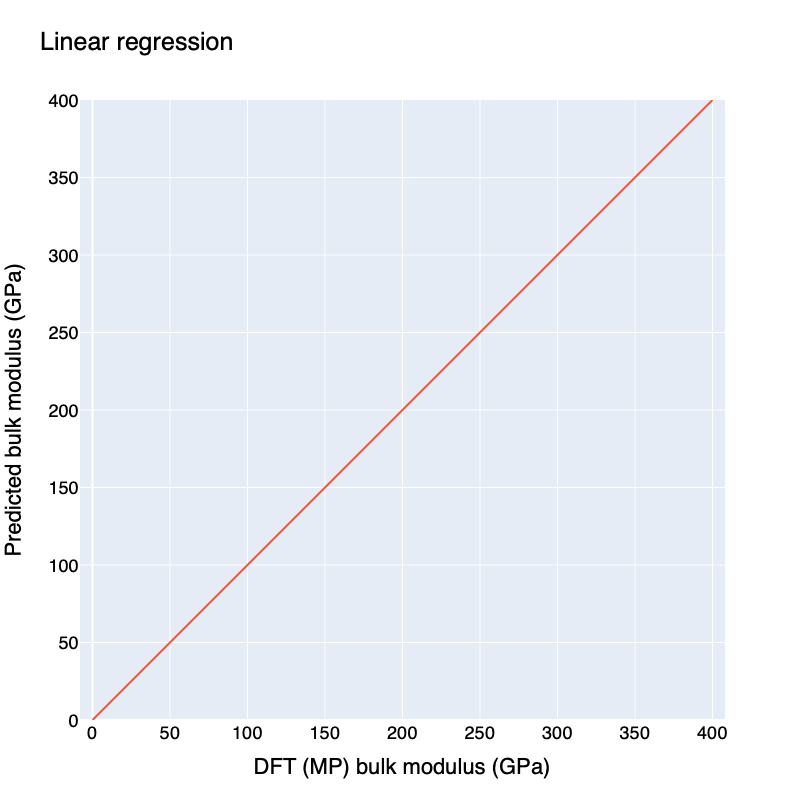

In [12]:
import plotly.graph_objects as PlotlyFig
from scipy import stats

# a line to represent a perfect model with 1:1 prediction
xy_params = {'x_col': [0, 400],
             'y_col': [0, 400],
             'color': 'black',
             'mode': 'lines',
             'legend': None,
             'text': None,
             'size': None}

xx=y
yy=lr.predict(X)

# Calculate the point density
kde = stats.gaussian_kde([xx,yy])
zz = kde([xx,yy])

# Sort the points by density, so that the densest points are plotted last
idx = zz.argsort()
xx, yy, z = xx[idx], yy[idx], zz[idx]

fig = PlotlyFig.Figure(data=PlotlyFig.Scattergl(
    x=xx,
    y=yy,
    mode='markers',
    marker=dict(
        size=5,
        color=z, #set color equal to a variable
        colorscale='Viridis', # one of plotly colorscales
    ),
    text=df['pretty_formula']
))

fig.update_layout(xaxis_title='DFT (MP) bulk modulus (GPa)',
                  yaxis_title='Predicted bulk modulus (GPa)',
                  title='Linear regression',
                  width=800,
                  height=800,
                  font=dict(family="Helvetica",
                            size=18, color="black")
    )

fig.update_yaxes(scaleanchor="x")

fig.add_trace(PlotlyFig.Scatter(x=[0,400], y=[0,400],
                    mode='lines'))

fig.update_layout(xaxis=dict(range=[0, 400]),
                  yaxis=dict(range=[0, 400]),
                  showlegend=False)

fig.show()

Great! We just fit a linear regression model to pymatgen features using matminer and sklearn. Now let’s use a Random Forest model to examine the importance of our features.

## 3. Follow similar steps for a Random Forest model

## 3.1 Fit the Random Forest model, get R2 and RMSE

In [14]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(X, y)
print('R2 = ' + str(round(rf.score(X, y), 3)))
print('RMSE = %.3f' % np.sqrt(mean_squared_error(y_true=y, y_pred=rf.predict(X))))

R2 = 0.985
RMSE = 8.318


## 3.2 Cross-validate the results

In [15]:
# compute cross validation scores for random forest model
scores = cross_val_score(rf, X, y, scoring='neg_mean_squared_error', cv=crossvalidation, n_jobs=-1)

rmse_scores = [np.sqrt(abs(s)) for s in scores]
print('Cross-validation results:')
print('Folds: %i, mean RMSE: %.3f' % (len(scores), np.mean(np.abs(rmse_scores))))

Cross-validation results:
Folds: 10, mean RMSE: 22.391


## 3.3 Plot the random forest model

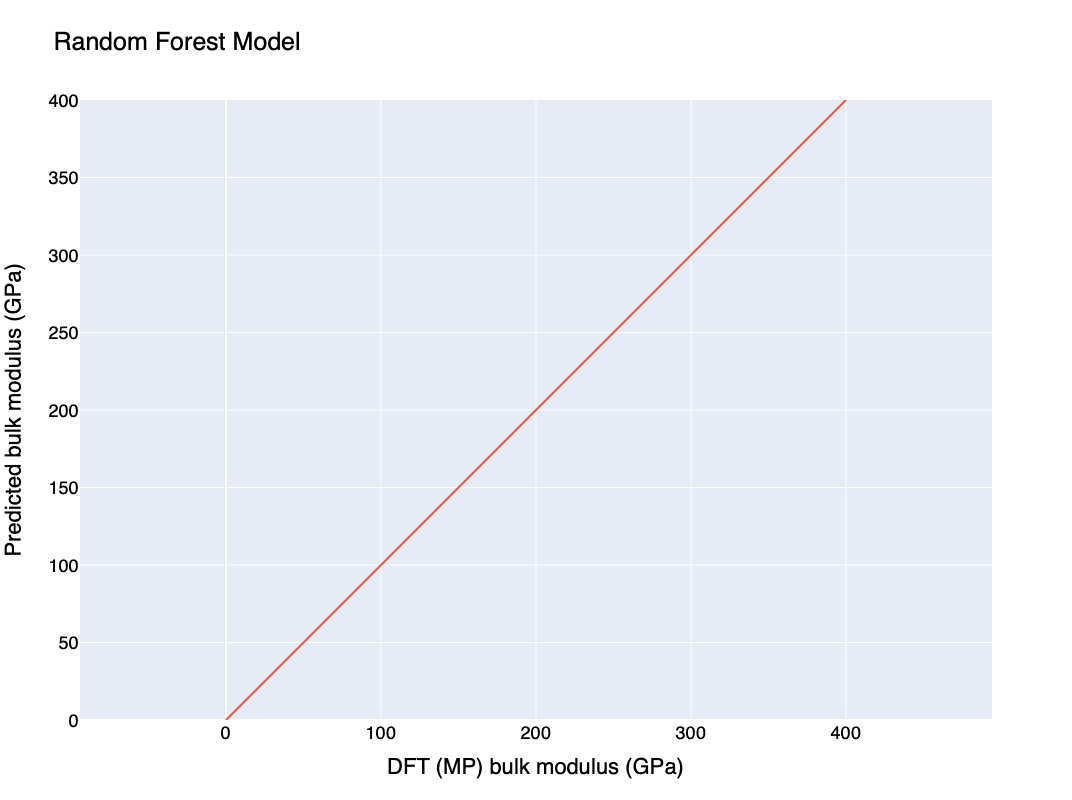

In [17]:
# a line to represent a perfect model with 1:1 prediction
xy_params = {'x_col': [0, 400],
             'y_col': [0, 400],
             'color': 'black',
             'mode': 'lines',
             'legend': None,
             'text': None,
             'size': None}

xx=y
#yy=rf.predict(X)
yy=cross_val_predict(rf, X, y, cv=crossvalidation)

# Calculate the point density
kde = stats.gaussian_kde([xx,yy])
zz = kde([xx,yy])

# Sort the points by density, so that the densest points are plotted last
idx = zz.argsort()
xx, yy, z = xx[idx], yy[idx], zz[idx]

fig = PlotlyFig.Figure(data=PlotlyFig.Scattergl(
    x=xx,
    y=yy,
    mode='markers',
    marker=dict(
        size=5,
        color=z, #set color equal to a variable
        colorscale='Viridis', # one of plotly colorscales
    ),
    text=df['pretty_formula']
))

fig.update_layout(xaxis_title='DFT (MP) bulk modulus (GPa)',
                  yaxis_title='Predicted bulk modulus (GPa)',
                  title='Random Forest Model',
                  width=800,
                  height=800,
                  font=dict(family="Helvetica",
                            size=18, color="black")
    )

fig.update_yaxes(scaleanchor="x")

fig.add_trace(PlotlyFig.Scatter(x=[0,400], y=[0,400],
                    mode='lines'))

fig.update_layout(xaxis=dict(range=[0, 400]),
                  yaxis=dict(range=[0, 400]),
                  showlegend=False)

fig.show()

This looks clearly better than the linear regression model and reflects the improved cross-validated R2 and RMSE.

You could (optionally) visualize the training error by replacing the code `cross_val_predict(rf, X, y, cv=crossvalidation)` in the above cell with `rf.predict(X)`. That would look a better still, but would not be an accurate representation of your prediction error.

## 3.4 Visualize the distribution of training and testing errors

In [ ]:
from sklearn.model_selection import train_test_split
X['pretty_formula'] = df['pretty_formula']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
train_formula = X_train['pretty_formula']
X_train = X_train.drop('pretty_formula', axis=1)
test_formula = X_test['pretty_formula']
X_test = X_test.drop('pretty_formula', axis=1)

rf_reg = RandomForestRegressor(n_estimators=50, random_state=1)
rf_reg.fit(X_train, y_train)

# get fit statistics
print('training R2 = ' + str(round(rf_reg.score(X_train, y_train), 3)))
print('training RMSE = %.3f' % np.sqrt(mean_squared_error(y_true=y_train, y_pred=rf_reg.predict(X_train))))
print('test R2 = ' + str(round(rf_reg.score(X_test, y_test), 3)))
print('test RMSE = %.3f' % np.sqrt(mean_squared_error(y_true=y_test, y_pred=rf_reg.predict(X_test))))

In [ ]:
import plotly.graph_objects as PlotlyFig

data_train=y_train-rf_reg.predict(X_train)
data_test=y_test-rf_reg.predict(X_test)

fig = PlotlyFig.Figure()
fig.add_trace(PlotlyFig.Histogram(x=data_train,
                                  name='Training',
                                  histnorm='probability',
                                  xbins=dict(
                                      start=-50.0,
                                      end=50,
                                      size=2
                                  )))

fig.add_trace(PlotlyFig.Histogram(x=data_test,
                                  name='Testing',
                                  histnorm='probability',
                                  xbins=dict(
                                      start=-50.0,
                                      end=50,
                                      size=2
                                  )))

fig.update_layout(xaxis_title='Bulk modulus prediction residual (GPa)',
                  yaxis_title='Probability',
                  title='Random Forest Regression Residuals',
                  barmode='stack',
                  width=1200,
                  height=600,
                  font=dict(family="Helvetica",
                            size=18, color="black")
    )

fig.show()

## 3.5 Plot the importance of the features we used

Let's see what are the most important features used by the random forest model.

In [ ]:
import plotly.graph_objects as PlotlyFig

importances = rf.feature_importances_
included = X.columns.values
indices = np.argsort(importances)[::-1]

fig = PlotlyFig.Figure(data=PlotlyFig.Bar(
    x=included[indices], y=importances[indices]))
    
fig.update_layout(yaxis_title='Importance',
                  title='Random Forest Model Features',
                  width=1200,
                  height=800,
                  font=dict(family="Helvetica",
                            size=18, color="black")
    )

fig.show()

Features relating to the materials volume per atom and density and the melting and boiling points of the components are the most important in the random forest model.

This concludes the tutorial! You are now familiar with some of the basic features of data retrieval and machine learning.

In [ ]:
# Import libraries
from sklearn.kernel_ridge import KernelRidge

krr = KernelRidge(alpha=1.0,kernel='rbf')
krr.fit(X, y)
print('R2 = ' + str(round(krr.score(X, y), 3)))
print('RMSE = %.3f' % np.sqrt(mean_squared_error(y_true=y, y_pred=krr.predict(X))))

In [ ]:
# compute cross validation scores for random forest model
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict

# Use 10-fold cross validation (90% training, 10% test)
crossvalidation = KFold(n_splits=10, shuffle=True)

scores = cross_val_score(krr, X, y, scoring='neg_mean_squared_error', cv=crossvalidation, n_jobs=-1)

rmse_scores = [np.sqrt(abs(s)) for s in scores]
print('Cross-validation results:')
print('Folds: %i, mean RMSE: %.3f' % (len(scores), np.mean(np.abs(rmse_scores))))